In [1]:
import numpy as np
import tensorflow as tf
import os

from keras.utils import np_utils
import cv2
from matplotlib import pyplot as plt
#tf.enable_eager_execution()

Using TensorFlow backend.


In [2]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [4]:
train_features.shape

(50000, 32, 32, 3)

In [0]:
def random_crop(input_image,padding_pixels=4,random_crop_size=(32,32)):
    assert input_image.shape[2]==3

    #pad for 4 pixels
    img = cv2.copyMakeBorder(input_image,padding_pixels,padding_pixels,padding_pixels,padding_pixels,cv2.BORDER_REPLICATE)
    height , width =img.shape[0],img.shape[1]
    dy,dx = random_crop_size
    x = np.random.randint(0,width - dx + 1)
    y = np.random.randint(0,height - dy + 1)
    return img[y:(y+dy),x:(x+dx),:]

#lambda_feat = lambda t : random_crop(t)
tr_seq = list(range(len(train_features)))
te_seq = list(range(len(test_features)))
train_func = lambda i:random_crop(train_features[i])
train_features = list(map(train_func,tr_seq))

train_features = np.asarray(train_features)


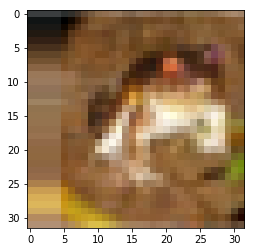

In [6]:
plt.imshow(train_features[0])

In [0]:
def get_cutout_eraser_and_random_crop(p=0.4,s_l=0.05,s_h=0.3,r_1=0.3,r_2=1/0.3,max_erasers_per_image=1,pixel_level=True,random_crop_size=(32,32),padding_pixels=4):
  
  assert max_erasers_per_image>=1 
  def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1,max_erasers_per_image+1)
        for i in range(mx):
          while True:
              s = np.random.uniform(s_l, s_h) * img_h * img_w
              r = np.random.uniform(r_1, r_2)
              w = int(np.sqrt(s / r))
              h = int(np.sqrt(s * r))
              left = np.random.randint(0, img_w)
              top = np.random.randint(0, img_h)

              if left + w <= img_w and top + h <= img_h:
                  break

          if pixel_level:
              c = np.random.uniform(v_l, v_h, (h, w, img_c))
          else:
              c = np.random.uniform(v_l, v_h)

          input_img[top:top + h, left:left + w, :] = c
        return input_img

  def preprocess_image(input_image):
    return eraser(input_image)
  
  return preprocess_image

In [0]:
x_train_mean = np.mean(test_features,axis=(0,1,2))
x_train_std = np.mean(test_features,axis=(0,1,2))

In [0]:
datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=0.5,featurewise_center=True, featurewise_std_normalization=True,preprocessing_function=get_cutout_eraser_and_random_crop())
datagen_aug.mean = np.array(x_train_mean, dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen_aug.std = np.array(x_train_std, dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
#datagen.fit(train_features)
train_generator = datagen_aug.flow(train_features,train_labels,batch_size=256)



In [0]:
x_test_mean = np.mean(test_features,axis=(0,1,2))
x_test_std = np.mean(test_features,axis=(0,1,2))

In [0]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.mean = np.array(x_test_mean, dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
test_datagen.std = np.array(x_test_std, dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
test_datagen.fit(test_features)
test_generator = test_datagen.flow(test_features,test_labels,batch_size=512)

In [0]:
# aug_img=np.zeros((256,32,32,3))
# train_gen = train_generator.next()
# aug_img[:256]= train_gen[0]

In [0]:
import h5py
f = h5py.File('aug_img.hdf5', 'w')
d = f.create_dataset('dataset', (500000,32,32,3),chunks=(256,32,32,3))
l = f.create_dataset('labels',(500000,10),chunks=(256,10))


batch_size=256
EPOCHS =20
aug_lbl=[]
tmp=0
for i in range(EPOCHS):
  print("tmp ", tmp)
  for j in range(len(train_generator)):
    initial = j*batch_size+tmp
    train_gen = train_generator.next()
    if(j == 195 ):
      final += 80
      d[initial:final]= train_gen[0]
      l[initial:final]= train_gen[1]
      continue 
      
    
    final = initial + 256
    d[initial:final]= train_gen[0]
    l[initial:final]= train_gen[1]
  
  tmp = final

# f.close()

  
  

tmp  0
tmp  50000
tmp  100000
tmp  150000
tmp  200000
tmp  250000
tmp  300000
tmp  350000
tmp  400000
tmp  450000
tmp  500000
tmp  550000
tmp  600000
tmp  650000
tmp  700000
tmp  750000
tmp  800000
tmp  850000
tmp  900000
tmp  950000


In [0]:
# tmp_aug=[]
# tmp_not_aug=[]
# for i in range(len(train_generator_aug)):
#   tmp_aug.append(train_generator_aug.next())
#   tmp_not_aug.append(train_not_aug.next())
  

##contains the 256 images batch --
#aug_images = np.asarray(tmp)
#wo_aug_images = 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


#Resnet Model Creation

In [0]:
# import time, math
# def init_pytorch(shape, dtype=tf.float32, partition_info=None):
#   fan = np.prod(shape[:-1])
#   bound = 1 / math.sqrt(fan)
#   return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

initializer = tf.keras.initializers.glorot_normal(seed=None)

W0815 14:12:49.983681 140405211772800 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
def ResNetBlock(input_layer, channels,stride=1):
  
  bn_1 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(input_layer)
  activation_layer_b1 = tf.keras.layers.Activation('relu')(bn_1)
  if(stride==2):
    block_layer_1 = tf.keras.layers.Conv2D(channels, (3,3) ,padding='same',kernel_initializer=initializer,use_bias=False)(activation_layer_b1)
    block_layer_1= tf.keras.layers.MaxPooling2D()(block_layer_1)
  else:
    block_layer_1 = tf.keras.layers.Conv2D(channels, (3,3), padding='same',kernel_initializer=initializer,use_bias=False)(activation_layer_b1)
  
  bn_2 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(block_layer_1)
  activation_layer_b2 = tf.keras.layers.Activation('relu')(bn_2) 
  block_layer_2 = tf.keras.layers.Conv2D(channels, (3,3), padding='same',kernel_initializer=initializer,use_bias=False)(activation_layer_b2)
   
  
  return block_layer_2
  

In [0]:
# from tf.keras.layers import Input, add, GlobalAveragePooling2D, Dense
#from tf.keras.models import Model

inputs = tf.keras.layers.Input(shape=(32, 32, 3))

x1 = tf.keras.layers.Conv2D(64, (3, 3),padding='same',kernel_initializer=initializer,use_bias=False)(inputs)   #32x32 
activation_x1 = tf.keras.layers.Activation('relu')(x1)
bn1 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(activation_x1)

# x2 = tf.keras.layers.Conv2D(64, (3, 3),padding='same',kernel_initializer=initializer)(bn1)   #32x32 
# activation_x2 = tf.keras.layers.Activation('relu')(x2)
# bn2 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(activation_x2)

# x3 = tf.keras.layers.Conv2D(64, (3, 3),padding='same')(activation_x2)   #32x32 
# activation_x3 = tf.keras.layers.Activation('relu')(x3)
# bn3 = tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(activation_x3)

# mx_p= tf.keras.layers.MaxPooling2D()(bn1)



##block 1

blk1 = ResNetBlock(bn1,64)  ##32x32
z1 = tf.keras.layers.add([blk1,bn1])

blk1_c = ResNetBlock(z1,64)
z1_c = tf.keras.layers.add([blk1_c,z1])

drp_1 = tf.keras.layers.SpatialDropout2D(0.1)(z1_c)


##block 2

blk2 = ResNetBlock(drp_1,128,stride=2)
one_blk = tf.keras.layers.Conv2D(128, (1, 1), padding='same',strides=2)(drp_1)
z2 = tf.keras.layers.add([blk2,one_blk])

blk2_c = ResNetBlock(z2,128)
z2_c = tf.keras.layers.add([blk2_c,z2])


drp_2 = tf.keras.layers.SpatialDropout2D(0.1)(z2_c)

##block3

blk3 = ResNetBlock(drp_2,256,stride=2)
one_blk_1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same',strides=2)(drp_2)
z3 = tf.keras.layers.add([blk3,one_blk_1])

blk3_c = ResNetBlock(z3,256)
z3_c = tf.keras.layers.add([blk3_c,z3])


drp_3 = tf.keras.layers.Dropout(0.1)(z3_c)
#block4

blk4 = ResNetBlock(drp_3,256,stride=2)
one_blk_2 = tf.keras.layers.Conv2D(256, (1, 1), padding='same',strides=2)(drp_3)
z4 = tf.keras.layers.add([blk4,one_blk_2])

blk4_c = ResNetBlock(z4,256)
z4_c = tf.keras.layers.add([blk4_c,z4])




avg_pool_layer = tf.keras.layers.GlobalAveragePooling2D()(z4_c)


fc_layer = tf.keras.layers.Dense(10, activation='softmax',kernel_initializer=initializer)(avg_pool_layer)


model = tf.keras.models.Model(inputs=inputs, outputs= fc_layer)


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 32, 32, 64)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 32, 64)   256         activation_3[0][0]               
______________________________________________________________________________________________

#Best LR would be 0.01

In [0]:
# for 24 epochs only

# MAX_LR= 0.2
# base_lr = 0.01
# p = 0
# def lr_func(epoch,lr):
#   lr = base_lr
#   #print("lwr",tf.train.get_or_create_global_step())
#   max_lr = MAX_LR
#   print("p value ",p)
#   if(p == 0):
#     lr = base_lr
#   elif(p>0 and p<5):
#     lr += (max_lr-base_lr)*(p)/5
#   else:
#     lr = max_lr - (max_lr-base_lr)*(p-5)/18
#   print("final lr ",round(lr,5))
  
#   p +=1
#   return round(lr,5)
  

In [0]:
opt = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True)
model.compile(optimizer=opt , loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
##previous approch ::

# sequence = list(range(len(tmp_aug)))
# #train_data = lambda t: print(t)
# sess = tf.compat.v1.Session()
# #train_data = lambda t: print(t)
# train_data = lambda t : (np.concatenate((np.array(tmp_aug[t][0]),np.array(tmp_not_aug[t][0])),axis=0),\
#                        np.concatenate((np.array(tmp_aug[t][1]),np.array(tmp_not_aug[t][1])),axis=0))
# #global_step = tf.train.get_or_create_global_step()
# #i=0
# #train_data_func = lambda: train_data(global_step)

# train_data_f = list(map(train_data,sequence))
# #test_data = lambda : test_generator.next()

In [0]:
# newimage = np.zeros((512*98,32,32,3))
# newlabel = np.zeros((512*98,10))

In [0]:
# import h5py
# with h5py.File('aug_img.hdf5', 'r') as f:
#     data = list(f['dataset'])
#     label = list(f['labels'])
    
# f.close()

In [0]:
data = tf.keras.utils.HDF5Matrix('aug_img.hdf5','dataset')
label = tf.keras.utils.HDF5Matrix('aug_img.hdf5','labels')

In [0]:
##from HDF5 ---
import random

train_data_aug_l = lambda i: (np.array(data[i:i+168]),np.array(label[i:i+168]))
train_data_wo_l = lambda i: (np.array(train_features[i:i+168]),np.array(train_labels[i:i+168]))

train_data_aug = lambda i: (np.array(data[i:i+256]),np.array(label[i:i+256]))
train_data_wo = lambda i: (np.array(train_features[i:i+256]),np.array(train_labels[i:i+256]))

num_seq = list(range(len(train_features)//512+1))


def data_generator():
  
  train_data= np.zeros(shape=(50000,32,32,3))
  train_lbl = np.zeros(shape=(50000,10))
  
  
  tmp=0
  for k in num_seq:
    aug_ran = random.randrange(0,len(data)-256)
    wo_aug = random.randrange(0,len(train_features)-256)

    inital=tmp
    if(k == 97):
      final = inital+336
      train_data[inital:final] = np.concatenate((train_data_aug_l(aug_ran)[0],train_data_wo_l(wo_aug)[0]),axis=0)
      train_lbl[inital:final] = np.concatenate((train_data_aug_l(aug_ran)[1],train_data_wo_l(wo_aug)[1]),axis=0)
    else:
      final  = inital+512
      train_data[inital:final] = np.concatenate((train_data_aug(aug_ran)[0],train_data_wo(wo_aug)[0]),axis=0)
      train_lbl[inital:final] = np.concatenate((train_data_aug(aug_ran)[1],train_data_wo(wo_aug)[1]),axis=0)

    tmp += 512
  
  return train_data,train_lbl
  
  


In [0]:
x,y = data_generator()

W0815 14:14:00.678377 140405211772800 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

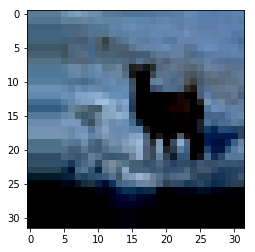

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
plt.imshow(x[4634])
y[4634]
#x.shape

In [0]:
filepath = "Resnet-13-test1.hdf5"
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

tmp_gen = tf.keras.preprocessing.image.ImageDataGenerator()

##Train the model
# model_info = model.fit_generator(train_generator,
#                                  steps_per_epoch=np.ceil(50000/128), epochs=24,  
#                                  validation_data = test_generator, verbose=1,callbacks=[checkpoint,LearningRateScheduler(lr_func, verbose=1)])

MAX_LR= 0.15
base_lr = 0.005
EPOCHS=24
for i in range(EPOCHS): 
  
  def lr_func(epoch,lr):
    lr = base_lr
    #print("lwr",tf.train.get_or_create_global_step())
    max_lr = MAX_LR
    
    if(i == 0):
      lr = base_lr
    elif(i>0 and i<5):
      lr += (max_lr-base_lr)*(i)/5
    else:
      lr = max_lr - (max_lr-base_lr)*(i-5)/18
    print("final lr ",round(lr,5))

    return round(lr,5)

  

for i in range(20):
  
  X_train,X_label = data_generator()
  model.fit(tmp_gen.flow(X_train,X_label,batch_size=512),steps_per_epoch=np.ceil(50000/512),
                               epochs=1,validation_data=test_generator)
                         # callbacks=[LearningRateScheduler(lr_func, verbose=1)]

98/98 [==============================] - 86s 877ms/step - loss: 0.3836 - acc: 0.8663 - val_loss: 0.9514 - val_acc: 0.7106


W0815 13:37:01.823027 140478476994432 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

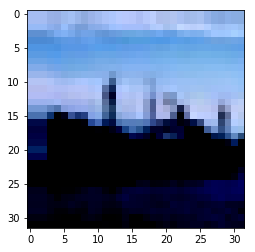

In [0]:
plt.imshow(X_train[19])
X_label[19]
#class_names = ['airplane','automobile','bird','cat','deer',
 #              'dog','frog','horse','ship','truck']

In [0]:
9